In [1]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('NASDAQ Training Data - 1st Jan 2016 to 1st Jan 2022.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-04,4897.649902,4903.089844,4846.979980,4903.089844,4903.089844,2218420000
1,2016-01-05,4917.839844,4926.729980,4872.740234,4891.430176,4891.430176,1927380000
2,2016-01-06,4813.759766,4866.040039,4804.689941,4835.759766,4835.759766,2168620000
3,2016-01-07,4736.399902,4788.020020,4688.169922,4689.430176,4689.430176,2552590000
4,2016-01-08,4722.020020,4742.569824,4637.850098,4643.629883,4643.629883,2288750000


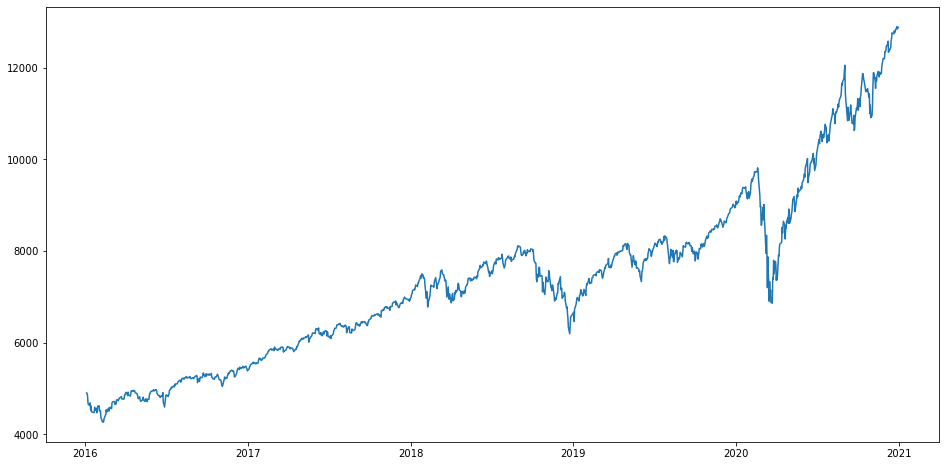

In [3]:
#setting index as date
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

#plot
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history')

In [4]:
data = df.filter(['Close'])
dataset = data.values
training_data_len = math.ceil(len(dataset) * .8)
training_data_len

1008

In [5]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.07370334],
       [0.07235268],
       [0.06590381],
       ...,
       [0.99430064],
       [0.99659199],
       [0.99870958]])

In [6]:
train_data = scaled_data[0:training_data_len, :]
x_train = []
y_train = []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i <= 61:
        print(x_train)
        print(y_train)
        print()

[array([0.07370334, 0.07235268, 0.06590381, 0.04895296, 0.04364744,
       0.04299414, 0.04854633, 0.03002813, 0.04033095, 0.02566789,
       0.02433923, 0.02372988, 0.02377276, 0.03757166, 0.02915124,
       0.03484822, 0.02332212, 0.02778316, 0.04020934, 0.04095303,
       0.02897284, 0.02750051, 0.02811676, 0.01115545, 0.00195888,
       0.0002224 , 0.00194032, 0.        , 0.00818642, 0.01959091,
       0.03095485, 0.02556596, 0.02752252, 0.03518879, 0.02742404,
       0.03194526, 0.03653141, 0.03748941, 0.03372229, 0.04897264,
       0.05057353, 0.05103689, 0.05214897, 0.05113305, 0.04424865,
       0.04720953, 0.04579399, 0.05579217, 0.05600179, 0.0534985 ,
       0.05758769, 0.05886425, 0.06125747, 0.06278891, 0.06427051,
       0.05815411, 0.05869163, 0.05791434, 0.06716188, 0.06978796])]
[0.06985284220377663]

[array([0.07370334, 0.07235268, 0.06590381, 0.04895296, 0.04364744,
       0.04299414, 0.04854633, 0.03002813, 0.04033095, 0.02566789,
       0.02433923, 0.02372988, 0.02

In [7]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(948, 60, 1)

In [8]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(x_train, y_train, batch_size = 1, epochs = 5)

Epoch 1/5
948/948 [==============================] - 71s 48ms/step - loss: 9.8797e-04
Epoch 2/5
948/948 [==============================] - 45s 47ms/step - loss: 3.7061e-04
Epoch 3/5
948/948 [==============================] - 45s 47ms/step - loss: 3.9953e-04
Epoch 4/5
948/948 [==============================] - 46s 49ms/step - loss: 2.3053e-04
Epoch 5/5
948/948 [==============================] - 46s 49ms/step - loss: 2.0693e-04


In [28]:
model.save('nasdaq price.h5')

In [4]:
from keras.models import load_model

model = load_model('nasdaq price.h5')

In [9]:
test_data = scaled_data[training_data_len - 60: , :]
x_test = []
y_test = dataset[training_data_len:, :]

for i in range (60, len(test_data)):
    x_test.append(test_data[i - 60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

rsme = np.sqrt(np.mean(predictions - y_test) ** 2)
rsme

70.16012505976093

C:\Users\user\AppData\Local\Temp/ipykernel_10520/731242048.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


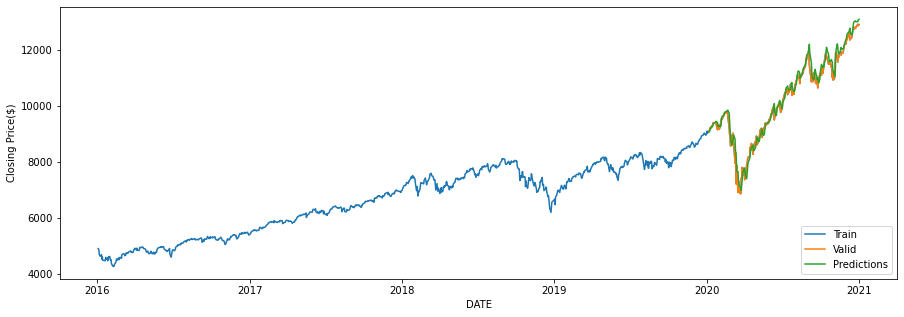

In [13]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions


plt.figure(figsize=(15,5))
plt.xlabel("DATE")
plt.ylabel("Closing Price($)")
plt.plot(df['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train','Valid','Predictions'],loc='lower right')
plt.show()


In [14]:
print('Validated close price with predicted closing price based on model')
print()
valid

Validated close price with predicted closing price based on model



,Close,Predictions
Date,,
2020-01-06,9071.469727,9061.322266
2020-01-07,9068.580078,9084.179688
2020-01-08,9129.240234,9097.188477
2020-01-09,9203.429688,9133.126953
2020-01-10,9178.860352,9196.035156
...,...,...
2020-12-24,12804.730469,12991.133789
2020-12-28,12899.419922,12993.191406
2020-12-29,12850.219727,13060.425781


In [15]:
last_60_days = data[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)
X_test = []
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1], 1))
pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
print ('Predicting the closing price for the next day')
print()
print(pred_price)

Predicting the closing price for the next day

[[13087.6875]]


In [10]:
test_data = pd.read_csv('NASDAQ Out of Time Data - 1st Jan 2022 to 4th Feb 2022.csv')


In [11]:
test_data['Close'].head(1)

0    15832.799805
Name: Close, dtype: float64

predicted closing price : 13087.687

Actual closing price: 15832.7998
    

In [14]:
# prediction using out of time data

In [15]:
data = test_data.filter(['Close'])
dataset = data.values
training_data_len = math.ceil(len(dataset) * .8)
training_data_len

19

In [16]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[1.        ],
       [0.91529096],
       [0.70458705],
       [0.696801  ],
       [0.63834986],
       [0.64114407],
       [0.72607086],
       [0.74015924],
       [0.58629752],
       [0.62135387],
       [0.46536735],
       [0.39817408],
       [0.3230778 ],
       [0.16779692],
       [0.20255873],
       [0.07520496],
       [0.07634611],
       [0.        ],
       [0.1684624 ],
       [0.35769864],
       [0.40048867],
       [0.42933917],
       [0.21211125]])

In [17]:
last_10_days = data[-10:].values
last_10_days_scaled = scaler.transform(last_10_days)
X_test = []
X_test.append(last_10_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
print ('Predicting the closing price for the next day')
print()
print(pred_price)

Predicting the closing price for the next day

[[14206.183]]


In [22]:
test_data = scaled_data[training_data_len - 10: , :]
x_test = []
y_test = dataset[training_data_len:, :]

for i in range (10, len(test_data)):
    x_test.append(test_data[i - 10:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (1,40,1))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

rsme = np.sqrt(np.mean(predictions - y_test) ** 2)
rsme

113.60546849999992

predicted closing price : 14206.183

Actual closing price: 14098.0
